In [1]:
%config IPCompleter.greedy=True
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
import sklearn.datasets, sklearn.model_selection
from progressbar import progressbar

# load the data
X, y = sklearn.datasets.fetch_openml('mnist_784', version=1, return_X_y=True, as_frame=False)
y, X = y.astype(int), X.reshape(-1, 784)
X[X < 128] = 0
X[X > 0] = 1
train_data, test_data, train_target, test_target = sklearn.model_selection.train_test_split(X, y, test_size=0.3, random_state=47)

Finally, here we are. We will build our first neural network today. I decided to take it the other way around - I will first show you the implementation and I will formalize it, define the concepts, and show the math behind.

# Implementation

So let's build our first neural network. Luckily for us, I take into consideration the architecture of the neural network in the last notebook. From the implementation point of view, we will not see anything new today.

I exported the code from the previous notebook into separate files. The file [src/utils_09.py](src/utils_09.py) contains definitions of losses, metrics, and optimizers (like `SGD`). The file [src/layers_09.py](src/layers_09.py) contains implementations of layers - `DenseLayer`, `SoftmaxLayer` and so on. Finally, the file [src/sequencemodel_09.py](src/sequencemodel_09.py) contains the definition of `SequenceModel` class - the exact copy of the `MulticlassLogisticRegression` class from the previous notebook. Here is only a subtle difference - we will pass the layers as constructor parameter rather than defining it inside. Let's import the classes.

In [2]:
from src.utils_09 import SGD, CategoricalCrossEntropyLoss, AccuracyMetric
from src.layers_09 import DenseLayer, SoftmaxLayer, SigmoidLayer
from src.sequencemodel_09 import SequenceModel

Now let's create and train the neural network. I can tell you right away - the only difference is the number of layers. Remember that logistic regression had one dense layer, the activation layer, and finally loss. The neural network will have one dense layer with $784$ inputs and $100$ outputs, then an activation layer (in this case sigmoid activation), then a dense layer again from $100$ inputs to $10$ outputs (the exact number of classes). The last dense layer follows an activation layer (softmax layer, as we have a classification task in hand) and finally the loss function.

Here it is:

In [3]:
optimizer = SGD(learning_rate=1e-4)
model = SequenceModel(layers=[
    DenseLayer(784, 100),
    SigmoidLayer(),
    DenseLayer(100, 10),
    SoftmaxLayer()
], loss=CategoricalCrossEntropyLoss(), metrices=[AccuracyMetric()], random_seed=42)
result = model.fit(train_data, train_target, optimizer, test_data, test_target, epochs=400, batch_size=128, progress=True)

100% (400 of 400) |######################| Elapsed Time: 2:09:10 Time:  2:09:10


As usual, let's visualize the results.

Train accuracy: 0.9121020408163265, Test accuracy: 0.8897142857142857


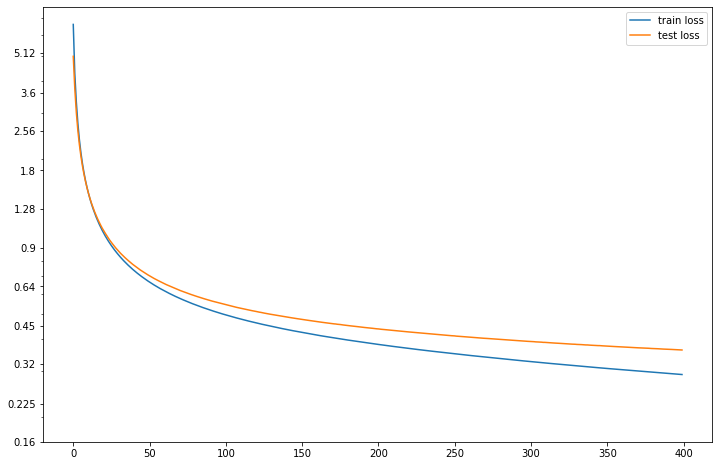

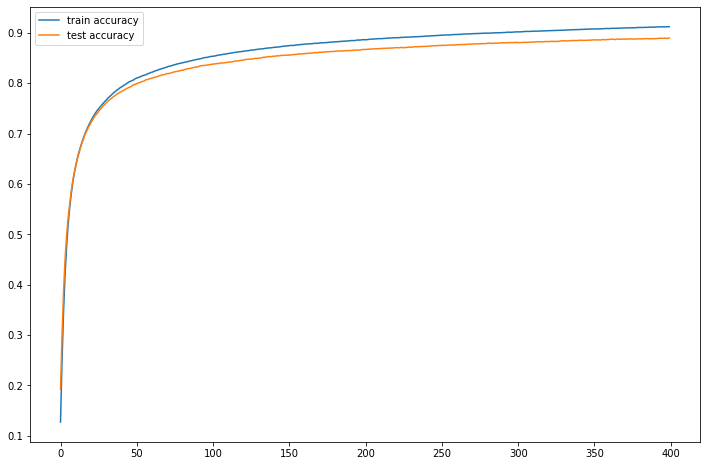

In [4]:
print(f"Train accuracy: {result['train_accuracy'][-1]}, Test accuracy: {result['test_accuracy'][-1]}")

plt.figure(figsize=(12,8))
plt.plot(result['train_loss'], label="train loss")
plt.plot(result['test_loss'], label="test loss")
plt.yscale('log')
ticks = [0.16, 0.225, 0.32, 0.45, 0.64, 0.9, 1.28, 1.8, 2.56, 3.6, 5.12]
plt.yticks(ticks=ticks, labels=ticks)
plt.legend()
plt.show()

plt.figure(figsize=(12,8))
plt.plot(result['train_accuracy'], label="train accuracy")
plt.plot(result['test_accuracy'], label="test accuracy")
plt.legend()
plt.show()

The results are not so bad, however still worse than one-to-one logistic regression. Nevertheless, the network learned and the predictions are around $88\%$ accurate. I don't want to dig much deeper into it, as I will discuss activation layers in some of the following notebook, but I can tell you right away, that the sigmoid activation layer is not the best choice. We may replace it with something better - ReLU activation function (rectified linear unit) with formula $max(0, x)$. I already implemented it, so let's see if something changes.

In [5]:
from src.layers_09 import ReLULayer

optimizer = SGD(learning_rate=1e-4)
model = SequenceModel(layers=[
    DenseLayer(784, 100, random_seed=46),
    ReLULayer(),
    DenseLayer(100, 10, random_seed=47),
    SoftmaxLayer()
], loss=CategoricalCrossEntropyLoss(), metrices=[AccuracyMetric()], random_seed=42)
result = model.fit(train_data, train_target, optimizer, test_data, test_target, epochs=400, batch_size=128, progress=True)

100% (400 of 400) |######################| Elapsed Time: 2:09:56 Time:  2:09:56


Train accuracy: 0.9497959183673469, Test accuracy: 0.9249047619047619


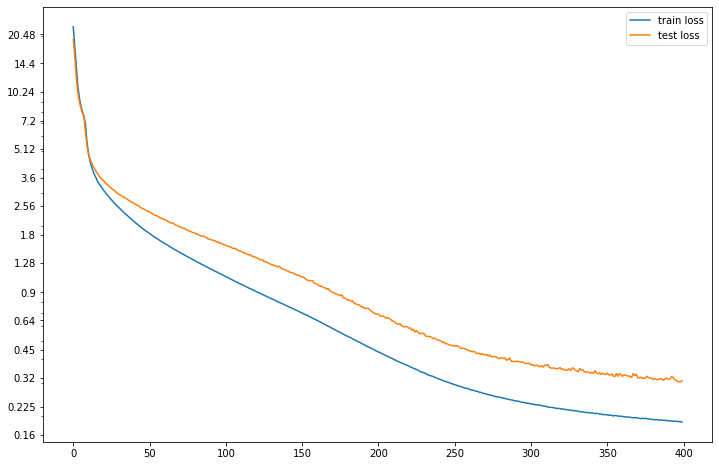

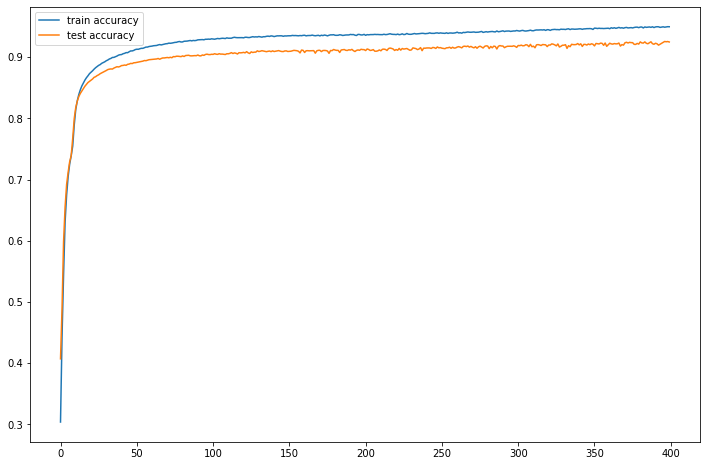

In [6]:
print(f"Train accuracy: {result['train_accuracy'][-1]}, Test accuracy: {result['test_accuracy'][-1]}")

plt.figure(figsize=(12,8))
plt.plot(result['train_loss'], label="train loss")
plt.plot(result['test_loss'], label="test loss")
plt.yscale('log')
ticks = [0.16, 0.225, 0.32, 0.45, 0.64, 0.9, 1.28, 1.8, 2.56, 3.6, 5.12, 7.2, 10.24, 14.4, 20.48]
plt.yticks(ticks=ticks, labels=ticks)
plt.legend()
plt.show()

plt.figure(figsize=(12,8))
plt.plot(result['train_accuracy'], label="train accuracy")
plt.plot(result['test_accuracy'], label="test accuracy")
plt.legend()
plt.show()

The test accuracy is around $92.49\%$ - the best result we achieved so far. Remember that we had $92.48\%$ accuracy with one-vs-one logistic regression model. Not a big improvement, but still an improvement nevertheless.

You may notice strange behavior around 10th epoch, when the loss decreased unexpectedly. That is probably caused by the weights initialization, but as I want to write about this topic in a separate notebook, I will ignore it for a now.

Now we see how the neural networks works - you may want to check the code once again if you are in doubt. Let's formalize it a little bit.

# Feed forward fully connected neural network

What we have seen is sometimes called *Feed forward fully connected neural network*. **Feed forward** from the fact, how the network works - it passes the data through layers sequentially. There are no connections from the later layer to the previous layer, no memory. Moreover, each layer is processed at once. The following layer can't start computing it's output unless it has all the outputs from the previous layer.

**Fully connected** is from the fact, that each neuron (remember that one neuron is represented as one row in the dense layer weight matrix) is connected with all the neurons from the previous layer. This connection is represented by the `DenseLayer` class, sometimes also called *Fully-connected layer* or shortly just *FC*.

The inference is usually called **forward pass** - the inputs pass through all the layers in the network. During the training, the model needs to compute gradients by backpropagation of the error, this is usually called **backward pass** or **backpropagation pass** (shortly **backprop pass**). Finally, the optimizer takes gradients of parameters and update them, this is usually called **update step**.

When we want to draw a neural network, they are usually shown using this representation:

![Colored Neural Network](https://upload.wikimedia.org/wikipedia/commons/4/46/Colored_neural_network.svg)

The circles represent neurons and the arrows connections between them. The red neurons, at the beginning of the network, are called **input neurons** and the whole layer is called **input layer**. Note that these neurons don't have inputs - they represent the input. They have no weights and no activation function. In fact, in our implementation, we don't even see the input layer - the input layer is the data itself. The inputs layer is a nice demonstration of the inputs data, but in reality, this layer is not implemented - the data in the matrix format simulate them.

On the other side, the green neurons are the **output neurons** in the **output layer**. The output from these neurons represents output of the network/model. They have weights and activation function - in our case that's the second dense layer and the softmax activation. Notice that the activation is not explicitly mentioned in the picture - it is mandatory that each neuron will have an activation function (expect the input ones), otherwise, there is no reason to have more layers (I will talk about it a little bit more later on). The picture represents more the architecture of the network (number of layers and neuron), rather than details like activation function.

All the layers between the input and output layers are called **hidden layers**. In our case, the hidden layer is the first dense layer and the sigmoid resp. the ReLU activation function. Once again, the activation function is not explicitly shown in the picture. Both in the picture and our model have only one hidden layer, but there can be multiple of them with different dimensionality. You need to make sure, the dimensions match. In our case, we have $784$ inputs and reduced it to $100$ outputs in the first hidden layer, the following layer needs to have $100$ inputs and can have an arbitrary number of outputs.

The layers are usually indexed - the hidden layer after the input layer is the first hidden layer, the following one layer is the second hidden layer, and so on. It's hard to tell, how many hidden layers you need and how much neurons should each hidden layer have. It depends on the problem at hand and there is no universal recipe - you need to try more options and pick the best one. That means that **number of layers and neurons are hyperparameters of the model**.

While the visualization above is nice for the introduction, drawing 784 neurons wouldn't be very descriptive. Because of this, you may sometimes see block schemas of the neural networks. For example in our case it would like this:

![Dense network block diagram](img/DenseBlock_09.svg)

Or a modified version where the author takes into account the dimension of the layer.

![Dense network scaled block diagram](img/BlockScaled_09.svg)

However, this still doesn't include what activation function neurons use. Sometimes you may see it included as a separate layer - a similar way it is defined in our network.

![Dense network scaled block diagram](img/WithActivation_09.svg)

We haven't talked about convolution neural networks, but you may see different visualization for them as well.

![Convolutional neural networks diagram](https://upload.wikimedia.org/wikipedia/commons/6/63/Typical_cnn.png)

# Mathematical definition

We may look at the neural network from the mathematical point of view as well. The dense layer represents a linear combination of $\mathbb{X}\mathbb{W}+\mathbb{b}$ and activation layer function. Together we may describe one layer as

$$
f(\mathbb{X}\mathbb{W}+\mathbb{b})
$$

As the output of one layer is input to the following layer, we may simply replace $\mathbb{X}$ with the output of the previous layer. The whole neural network can then be described as

$$
f_k(f_{k-1}(\dots f_2(f_1(\mathbb{X}\mathbb{W_1}+\mathbb{b_1})\cdot\mathbb{W_2}+\mathbb{b_2}) \dots )\cdot\mathbb{W_k}+\mathbb{b_k})
$$

This is the output of the neural network.

Then there is the **backpropagation algorithm**. That is exactly what the layer is doing when we call the `gradient` method on it. The function receives gradient from the following layer. This gradients tell, how each output should change in order to minimalize the loss. The layer may compute the gradient of its weights (in case of the dense layer) and then computes gradient with respect to inputs - how each input should change to minimalize the loss. Once again, we just exploited the chain rule.

$$
\frac{\partial f(g(x))}{\partial x}=\frac{\partial f(g(x))}{\partial g(x)}\cdot\frac{\partial g(x)}{\partial x}
$$

In the end, we want to know the gradients of weights. The error is propagated back through the layers and therefore the **backpropagation algorithm**.

We will start from the last, output layer, as it is the first layer in the context of the backpropagation algorithm.

$$
\frac{\partial \mathcal{L}}{\partial w_i} = \frac{\partial \mathcal{L}}{\partial f(\pmb{x}\pmb{w}^T)} \cdot \frac{\partial f(\pmb{x}\pmb{w}^T)}{\partial \pmb{x}\pmb{w}^T} \cdot \frac{\partial \pmb{x}\pmb{w}^T}{\partial w_i}
$$

This is the exact equation we had for the logistic regression. Unlike logistic regression, we need to propagate the error backward - in other words, we need a gradient of the loss with respect to the last layer's inputs.

$$
\frac{\partial \mathcal{L}}{\partial y_h} = \frac{\partial \mathcal{L}}{\partial f(y_h w^T)} \cdot \frac{\partial f(y_h w^T)}{\partial y_h w^T} \cdot \frac{\partial y_h w^T}{\partial y_h}
$$

Here $y_1, y_2, \dots, y_h$ denote outputs of the first hidden layer, second hidden layer up to the last hidden layer.

For hidden layers, the equation is a bit more complicated - it needs to receive gradient from the next layer (gradient of the loss with respect to layer's outputs) and after that, it can compute gradients of weights. Formally

$$
\frac{\partial \mathcal{L}}{\partial w_{ij}^l} = \sum_k \left( \frac{\partial \mathcal{L}}{\partial y_{l+1}^k} \cdot \frac{\partial y_{l+1}^k}{\partial y_l^j} \right) \cdot \frac{\partial y_l^j}{\partial y_{l-1} w^T} \cdot \frac{\partial y_{l-1} w^T}{\partial w_{ij}^l}
$$

Here we want to obtain gradient of loss in respect to weight from neuron $i$ in layer $l-1$ to neuron $j$ in layer $l$ - denoted as $w_{ij}^l$. We start by iterating over all neurons in the following $l+1$ layer (the $k$ index in the sum), compute the gradient of the loss with respect to the output this neuron followed by the gradient of its output in respect to its $j$ input. In the formula, the term $y_{l+1}^k$ represents *k-th* output of layer $l+1$. Note that the sum part of the equation corresponds to the value we return from the `backward` method call.

Finally, the gradient of neuron's input with respect to weight is computed - all we need to apply afterward is to make the update step.

Similarly is computed gradient of the loss with respect to the hidden layer's input.

$$
\frac{\partial \mathcal{L}}{\partial y_{l-1}} = \sum_k \left( \frac{\partial \mathcal{L}}{\partial y_{l+1}^k} \cdot \frac{\partial y_{l+1}^k}{\partial y_l^j} \right) \cdot \frac{\partial y_l^j}{\partial y_{l-1} w^T} \cdot \frac{\partial y_{l-1} w^T}{\partial y_{l-1}}
$$

You don't need to remember the equations - more important is to understand how the gradient is propagated through layers and how to obtain gradients of loss with respect to weights. Moreover, modern frameworks like PyTorch and TensorFlow can calculate gradients automatically - a topic we will see in the following notebook.